In [413]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, SplineTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import tensorflow as tf


In [414]:
df = pd.read_csv("../files/BRISTOR_Zegoland_all_%.csv")

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

In [415]:
X=df.iloc[:,8:13]
y=df.iloc[:,4:5]

data=pd.concat([y,X],axis=1)

data.head()

,Value,DemandShareA,newPatientShareA,newPatientShareB,totalPatientShareA,totalPatientShareB
Date,,,,,,
2021-11-01,56305.84,0.013829,0.05,0.001,0.01,0.000
2021-12-01,35581.00,0.013842,0.06,0.021,0.01,0.001
2022-01-01,41136.88,0.013942,0.05,0.026,0.01,0.002
2022-02-01,41689.80,0.014830,0.04,0.041,0.02,0.004
2022-03-01,54587.28,0.016513,0.05,0.028,0.02,0.005


In [416]:
# List of columns to create lags for
columns_to_lag = ['Value']

In [417]:
# Create lagged features
def create_lagged_features(data, lags):
    lagged_data = pd.DataFrame()
    for lag in range(1, lags + 1):
        #lagged_data[f'X_lag{lag}'] = data['DemandShareA'].shift(lag)
        lagged_data[f'y_lag{lag}'] = data['Value'].shift(lag)
    lagged_data['y'] = data['Value']  # Target variable
    lagged_data.dropna(inplace=True)  # Drop rows with NaN values
    return lagged_data

lagged_data = create_lagged_features(data, lags=1)
lagged_data.head()

,y_lag1,y
Date,,
2021-12-01,56305.84,35581.00
2022-01-01,35581.00,41136.88
2022-02-01,41136.88,41689.80
2022-03-01,41689.80,54587.28
2022-04-01,54587.28,40157.08


In [418]:
#features = lagged_data[['X_lag1', 'y_lag1', 'X_lag2', 'y_lag2']]
features = lagged_data[['y_lag1']]
target = lagged_data['y']

In [419]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [420]:
# Determine the split index
split_index = int(len(features_scaled) * 0.8)

# Split the data while preserving time order
X_train, X_test = features_scaled[:split_index], features_scaled[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

In [421]:
model=Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge()),
    
])

In [422]:
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('model', Ridge())])

In [423]:
pred_values_train= model.predict(X_train)   

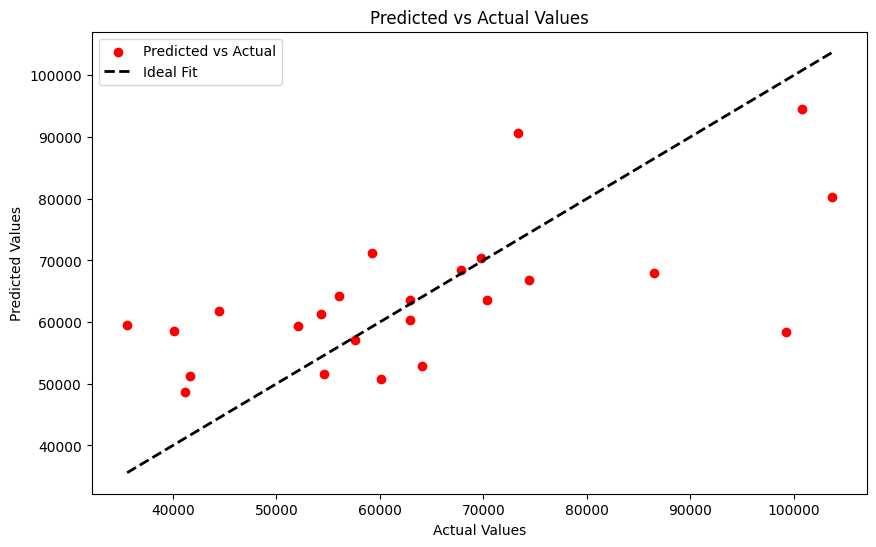

In [424]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train, pred_values_train, color='red', label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()

In [425]:
X=df.iloc[:,8:13]
y=df.iloc[:,4:5]

data=pd.concat([y,X],axis=1)

data.head()

,Value,DemandShareA,newPatientShareA,newPatientShareB,totalPatientShareA,totalPatientShareB
Date,,,,,,
2021-11-01,56305.84,0.013829,0.05,0.001,0.01,0.000
2021-12-01,35581.00,0.013842,0.06,0.021,0.01,0.001
2022-01-01,41136.88,0.013942,0.05,0.026,0.01,0.002
2022-02-01,41689.80,0.014830,0.04,0.041,0.02,0.004
2022-03-01,54587.28,0.016513,0.05,0.028,0.02,0.005


In [426]:
last_sequence = X_train[-1:]    
last_sequence

array([[0.92387003]])

In [427]:
forecast = []
next_value = model.predict(last_sequence)
forecast.append(next_value)
    # Shift the sequence forward
sequence = np.roll(last_sequence, -1)

sequence[-1] = next_value
sequence

array([[94558.09186165]])

In [428]:

# Inverse transform the forecasted values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

# Create a range of datetime values for the forecast
forecast_index = pd.date_range(start=data.index[-1], periods=n_forecast + 1, freq='M')[1:]


In [429]:

# Recursive forecasting
n_forecast_steps = 10  # Number of future steps
future_predictions = []

for _ in range(n_forecast_steps):
    last_sequence = last_sequence   
    next_value = model.predict(last_sequence)
    future_predictions.append(next_value)
    # Shift the sequence forward
    sequence = np.roll(last_sequence, -1)
    sequence[-1] = next_value
    X_train = np.concatenate([X_train, sequence], axis=0)
    

In [430]:
future_predictions

[array([94558.09186165]),
 array([94558.09186165]),
 array([94558.09186165]),
 array([94558.09186165]),
 array([94558.09186165]),
 array([94558.09186165]),
 array([94558.09186165]),
 array([94558.09186165]),
 array([94558.09186165]),
 array([94558.09186165])]

In [431]:
future_predictions=np.array(future_predictions)

In [432]:
n_forecast_steps=np.array(range(0,n_forecast_steps))

n_forecast_steps

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

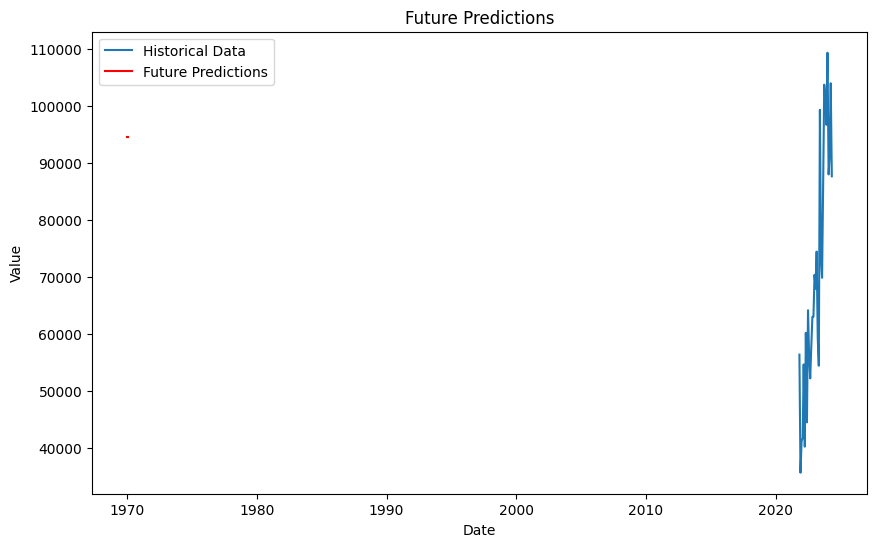

In [433]:
# Plot future predictions with the orginal data but future data starts after training data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Value'], label='Historical Data')
plt.plot(n_forecast_steps, future_predictions , label='Future Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Future Predictions')
plt.legend()
plt.show()



Epoch 1/50


/Users/anastasiaganshof/anaconda3/envs/Bio-210/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 5580334080.0000 - val_loss: 7656705536.0000
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5725308416.0000 - val_loss: 7578050560.0000
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5552671744.0000 - val_loss: 7469842432.0000
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5398517248.0000 - val_loss: 7388724224.0000
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5331732992.0000 - val_loss: 7307559424.0000
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5569481728.0000 - val_loss: 7225759744.0000
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5312129536.0000 - val_loss: 7143647744.0000
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5379691008.0000 - val_loss: 7060835840.0000
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5259567104.0000 - val_loss: 6977281536.0000
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4892684288.0000 - val_loss: 6893063680.0000

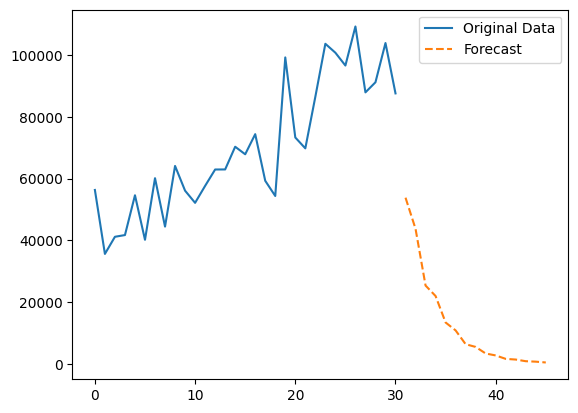

In [434]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Example data

y = data['Value'].dropna().values 
# Prepare data
n_steps = 3
X_train, y_train = [], []
for i in range(len(y) - n_steps):
    X_train.append(y[i:i + n_steps])
    y_train.append(y[i + n_steps])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], n_steps, 1))  # Reshape to 3D

# Build model
model = Sequential([
    LSTM(30, activation='relu', input_shape=(n_steps,1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.01)

# Recursive forecasting
last_sequence = y[-n_steps:].reshape((1, n_steps, 1))  # Last known values
forecast = []
for _ in range(15):  # Predict 5 steps ahead
    next_value = model.predict(last_sequence)[0, 0]
    forecast.append(next_value)
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_value

# Plot
all_data = np.concatenate([y, forecast])
plt.plot(range(len(y)), y, label='Original Data')
plt.plot(range(len(y), len(all_data)), forecast, label='Forecast', linestyle='--')
plt.legend()
plt.show()
